In [ ]:
# Homework 2: Boosting and Bagging
#
# This python notebook is for Homework 2 of CS6350 at the University of Utah. It takes the Decision Trees from the previous
# homework and builds on them to implement the Boosting and Bagging algorithms.
#
# @author: Scott Merkley
# @version: October 06, 2024

# **Import Libraries**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os

# **Gain Functions, Node Class, and ID3 Algorithm**

In [3]:
####################################################################################################################################################################################################################################
#                                                                                                                                                                                                                                  #
#                                                                                                 Entropy and Gain Functions                                                                                                       #
#                                                                                                                                                                                                                                  #
####################################################################################################################################################################################################################################

# This function takes in a positive and negative numbers for one attribute of a set, the total
# of their entries and calculates the entropy for that single array.
#
def Calculate_Single_Entropy(arr):
  tot = np.sum(arr)
  H_entropy = 0
  for val in arr:
    if val == 0:
      return 0
    else:
      H_entropy += -(val / tot) * math.log2(val / tot)
  return H_entropy


# This function takes in the positive and negative numbers of chances that the attribute has,
# calculates, and returns the entropy.
#
def Entropy(entropy_arr):

  if not isinstance(entropy_arr, np.ndarray):
    entropy_arr = np.array(entropy_arr)

  try:
    if entropy_arr.shape[1] > 1:
      H_entropy = 0
      for arr in entropy_arr:
            H_entropy += np.sum(arr) / np.sum(entropy_arr) * Calculate_Single_Entropy(arr)
      return H_entropy
  except:
      return Calculate_Single_Entropy(entropy_arr)


# This function calculates the gain from given positive and negative values in an array so
# that the decision tree can decide which attribute to use next.
#
# Format of 'entropies':
#
#    [[pos, neg],     First attribute with pos, neg values
#     [pos, neg],     Second attribute with pos, neg values
#     [pos, neg],
#        ...
#     [pos, neg]]     Total pos, neg of system
#
def Gain(df):

  # Check if df is a df, if not, make it a df
  entropies = []
  for col_name in df.columns:
    col_entropy = []
    for val in pd.crosstab(df[col_name], df[df.columns[-1]]).values:
        col_entropy.append(val)

    if col_name == df.columns[-1]:
      # You need to collate these values so that they are in the form [9, 5] instead of [9, 0], [0, 5]
      col_entropy = [max(elements) for elements in zip(*col_entropy)]

    # I want to calculate the entropy for each column here
    entropies.append(Entropy(col_entropy))

  # Calculating the Gain
  entropies = entropies[-1] - entropies
  entropies = entropies[:-1]
  return np.array(entropies)


# This function calculates the Majority Error of a given dataframe, it assumes that the first columns are the attributes and the last column is the labels.
# It returns an array of errors to find the majority from.
#
def Majority_Error(df):
  errors = []
  for col_name in df.columns[:-1]:
    errors.append(1 - pd.crosstab(df[col_name], df[df.columns[-1]]).sum(axis = 1).max() / pd.crosstab(df[col_name], df[df.columns[-1]]).values.sum())
  return np.array(errors)




# This function calculates the Gini Index of a given dataframe, it assumes that the first columns are the attributes and the last column is the labels.
# It returns an array of errors to find the Gini from.
#
def Gini_Index(df):
  gini = []
  for col_name in df.columns[:-1]:
    gini_value = 0
    for val in pd.crosstab(df[col_name], df[df.columns[-1]]).values:
      gini_value += (np.sum(val) / pd.crosstab(df[col_name], df[df.columns[-1]]).values.sum())**2
    gini.append(1 - gini_value)
  return np.array(gini)





####################################################################################################################################################################################################################################
#                                                                                                                                                                                                                                  #
#                                                                                                     Node Class                                                                                                                   #
#                                                                                                                                                                                                                                  #
####################################################################################################################################################################################################################################



# This class represents the nodes for the decision tree. The data can be thought of as the name of the tree,
# the children are the leaf nodes.
#
class Node:
  def __init__(self, data = None):
    self.data = data
    self.children = {}
    self.is_leaf = False

  def add_child(self, branch_name, child_node):
    self.children[branch_name] = child_node

  def __getitem__(self, child_name):
    return self.children[child_name]

  def __str__(self):
    return str(self.data)

  def print_tree(self, level = 0):
        # Print the current node's data with indentation
        print(" " * level + str(self.data))
        # Recursively print the children nodes
        for child in self.children.values():
            child.print_tree(level + 2)  # Increases indentation for children



####################################################################################################################################################################################################################################
#                                                                                                                                                                                                                                  #
#                                                                                                     ID3 Algorithm                                                                                                                #
#                                                                                                                                                                                                                                  #
####################################################################################################################################################################################################################################



# This function is the decision tree function. It takes in a given data set S, Attributes (ie. column names without the label column name), and
# the Labels for the dataset. It then uses the Node class and Gain functions to create a decision tree for the data set. The user is also able to
# specify a depth for the tree to try to maintain overfitting or underfitting.
#
def ID3(S, Attributes, Labels, method = 'Gain', max_depth = None, current_depth = 0):

  if max_depth != None and not isinstance(max_depth, int):
    max_depth = int(max_depth)

  if not isinstance(Attributes, list):
    attributes_list = []
    for a in Attributes:
      attributes_list.append(a)
    Attributes = attributes_list

  df = pd.DataFrame(S, columns = Attributes)
  outcome_column_name = 'Outcomes'
  df[outcome_column_name] = Labels

  if len(df[outcome_column_name].unique()) == 1:
    leaf = Node(df[outcome_column_name].unique()[0])
    leaf.is_leaf = True
    return leaf

  elif len(Attributes) == 0:
    leaf = Node(df[outcome_column_name].value_counts().idxmax())
    leaf.is_leaf = True
    return leaf # Most common label, not the highest number.

  else:
    if method == 'ME':
      A = Attributes[np.argmax(Majority_Error(df))]
    elif method == 'GI':
      A = Attributes[np.argmax(Gini_Index(df))]
    else:
      A = Attributes[np.argmax(Gain(df))] # Will return the 'best' attribute (aka. column header) that splits S

    # Add a new node until the specified depth
    root = Node(A)

    if max_depth == None or current_depth < max_depth:
      for v in df[A].unique():
        # root.add(Node(v)) # Adding a new tree branch corresponding to A = v
        S_v = df[df[A] == v]

        if S_v.empty:
          leaf = Node(df[outcome_column_name].value_counts().idxmax())
          leaf.is_leaf = True
          root.add_child(v, leaf)

        else:
          # In order to make the tree a certain depth, you could use a count depth on the node class! Then instead of running a leaf you only add a branch (aka. .add())
          L_v = S_v[outcome_column_name].values
          S_v = S_v.drop([A, outcome_column_name], axis = 1)
          A_v = Attributes.copy()
          A_v.remove(A)
          root.add_child(v, ID3(S_v.values, A_v, L_v, method = method, max_depth = max_depth, current_depth = current_depth + 1))

    else:
      leaf = Node(df[outcome_column_name].value_counts().idxmax())
      leaf.is_leaf = True
      return leaf

    return root


####################################################################################################################################################################################################################################
#                                                                                                                                                                                                                                  #
#                                                                                                    Testing Decision Tree Functions                                                                                               #
#                                                                                                                                                                                                                                  #
####################################################################################################################################################################################################################################


# This function takes in a decision tree, the test data (as a pandas dataframe), and the row index. It returns the label value that the decision tree returns.
# The function recursively moves down the tree until a leaf node is reached. The leaf nodes value is then returned up the tree.
#
def Test_Tree(tree, test, row_index):
  if tree.is_leaf:
    return tree.data
  else:
    return Test_Tree(tree[test[tree.data][row_index]], test, row_index)



# This function is the driver method for testing the a decision tree. An input tree, test dataframe, outcome column name, and beginning and ending depths
# are required to make the calculations. It then traverses the tree, tests whether the outcomes in the decision tree are the same as the test data.
#
def Test_Decision_Tree(tree, test_df, outcome_column_name, begin_depth, end_depth):
  correct_dictionary = {}
  for m in ['ME', 'GI', 'Gain']:
    correct_list = []
    for depth in range(begin_depth, end_depth):
      tree = ID3(test_df.drop(outcome_column_name, axis = 1).values, list(test_df.drop(outcome_column_name, axis = 1).columns), test_df[outcome_column_name].values, method = m, max_depth = depth)
      is_correct = 0
      for row_index in range(0, len(test_df)):
        try:
          if Test_Tree(tree, test_df, row_index) == test_df[outcome_column_name][row_index]:
            is_correct += 1
        except:
          is_correct += 0
      correct_list.append(is_correct)
    correct_dictionary[m] = correct_list
  return correct_dictionary

# **Gradient Descent**

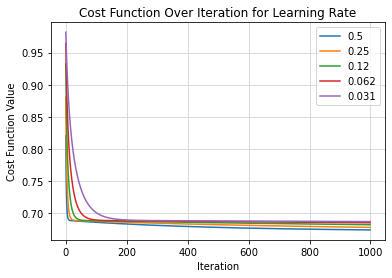

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



columns = ['Cement', 'Slag', 'Fly ash', 'Water', 'SP', 'Coarse Aggr', 'Fine Aggr', 'y']

# Load the Dataset
cement_train = pd.read_csv('concrete/train.csv', names = columns)
cement_test = pd.read_csv('concrete/test.csv', names = columns)


# Normalize the Data
cement_train = (cement_train - np.mean(cement_train, axis = 0)) / np.std(cement_train, axis = 0)
cement_test = (cement_test - np.mean(cement_test, axis = 0)) / np.std(cement_test, axis = 0)


# Define a Cost Function
def Cost_Function(X, y, w):
  cost = X.dot(w) - y
  loss = 1 / X.shape[0] * np.sum(cost**2)
  return loss


# Create a Batch Gradient Descent Function
def Batch_Gradient_Descent(X, y, learning_rate = 0.01, max_iterations = 1000):
  # Initialize Weights to Zero
  w = np.zeros(X.shape[1])
  cost_over_time = []
  norm_diff = np.inf # Initialize the norm to infinity
  iteration = 0

  while norm_diff > 1e-6 and iteration < max_iterations:
    predictions = X.dot(w)
    errors = predictions - y
    gradient = (1 / X.shape[0]) * (X.transpose().dot(errors)) # Actually 1/m instead of 1/2
    w_new = w - learning_rate * gradient
    norm_diff = np.linalg.norm(w_new - w)
    w = w_new
    cost = Cost_Function(X, y, w)
    cost_over_time.append(cost)

    iteration += 1

  return w, cost_over_time


for r in [2**-i for i in range(1, 6)]:
  weights_bgd, cost_over_time = Batch_Gradient_Descent(cement_train.drop('y', axis = 1).values, cement_train['y'].values, learning_rate = r)
  test_cost = Cost_Function(cement_test.drop('y', axis = 1).values, cement_test['y'].values, weights_bgd)

  plt.plot(cost_over_time, label = f'{r:0.2}')
  plt.title(f'Cost Function Over Iteration for Learning Rate')
  plt.xlabel('Iteration')
  plt.ylabel('Cost Function Value')
  plt.grid(color = 'lightgrey')
  plt.legend()
  # plt.show()


In [5]:
test_cost

0.7976998696995595

# **Stochastic Gradient Descent**

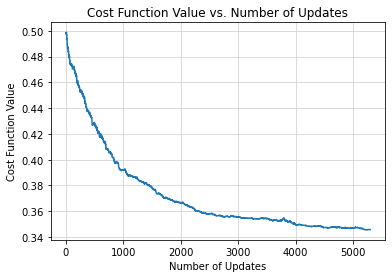

In [6]:
import numpy as np
import matplotlib.pyplot as plt


def Stochastic_Gradient_Descent(X, y, learning_rate, iterations):
  m, n = X.shape
  w = np.zeros(n)
  cost_over_time = []

  for iter in range(iterations):
    for i in range(m):
      # Randomly Sample from X
      random_index = np.random.randint(m)
      x_i = X[random_index]
      y_i = y[random_index]

      # Predict based on current example
      prediction = x_i.dot(w)
      error = y_i - prediction
      w += learning_rate * error * x_i # Update weights

      # Calculate the Cost
      cost = (1 / (2 * m)) * np.sum((X.dot(w) - y)**2)
      cost_over_time.append(cost)

    # Playing around with modifying the learning rate based on the sign of the cost
    # learning_rate -= 0.0001 * np.sign(cost)
  return w, cost_over_time

def Calculate_Optimal_Weights(X, y):
  # Using the Normal Equation, we can calculate the optimal weights
  return np.linalg.inv(X.transpose().dot(X)).dot(X.transpose()).dot(y)


weights_sgd, cement_cost = Stochastic_Gradient_Descent(cement_train.drop('y', axis = 1).values, cement_train['y'].values, 0.001, 100)
plt.plot(cement_cost)
plt.title("Cost Function Value vs. Number of Updates")
plt.xlabel("Number of Updates")
plt.ylabel("Cost Function Value")
plt.grid(color = 'lightgrey')
plt.show()

In [7]:
# Comparing Descents

# Batch Gradient Descent
weights_bgd, cost_over_time = Batch_Gradient_Descent(cement_train.drop('y', axis = 1).values, cement_train['y'].values, learning_rate = 2e-2)
print("Batch Gradient Descent:      ", end = '')
print(", ".join(f'{w:0.3}' for w in weights_bgd))

# Stochastic Gradient Descent
weights_sgd, cement_cost = Stochastic_Gradient_Descent(cement_train.drop('y', axis = 1).values, cement_train['y'].values, 0.001, 100)
print("Stochastic Gradient Descent: ", end = '')
print(", ".join(f'{w:0.3}' for w in weights_sgd))

# Optimal weight vector (Closed Form)
optimal_weights = Calculate_Optimal_Weights(cement_train.drop('y', axis = 1).values, cement_train['y'].values)
print("Optimal Weight Vector:        ", end = '')
print(", ".join(f'{w:0.4}' for w in optimal_weights))

Batch Gradient Descent:      -0.0641, -0.222, -0.243, 0.57, -0.0297, 0.305, 0.02
Stochastic Gradient Descent: -0.113, -0.271, -0.275, 0.558, -0.0611, 0.247, 0.0203
Optimal Weight Vector:        0.9477, 0.851, 0.9419, 1.394, 0.1259, 1.709, 1.186
